# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**Determine the Business Objective**

The goal of this data analysis task is to determine what attributes of a car correlates well, or predicts the price of a car. This is a supervised learning exercise. We have the price of cars that were sold, along with features associated with the cars. Specifically, this is a regression problem.

We will divide the data set into two parts: a training and validation set. We will train a regression model on part of the training data, and validate the model on the other data set that the model has not seen.

**Data Understanding**

The data set provided, in general, includes features of cars, along with the price. That data is consistent with the goals of the exercise.

The data set is fairly large. There are over 400k samples provided. Some of that data may have missing values. Some columns may not be relevant. But at least the data appears to be compatible with the task.

To understand the data, we will look at features one at a time to get a sense of the type of data it contains, whether there are missing values and how we want to address that, and assess the descriptive statistics for that feature. We may also compare with other features to see if relationships emerge between the various features and the target. 

**Data Mining Goals**
  - Determine the features of cars that most influence the price of a vehicle.
  - For these features, identify what values leads to higher vehicle prices.
  - Determine how to model the relationships of the features, linear vs. polynomial features.
  - Determine what cross validation strategy to use to tune hyperparameters that yield optimized regression model


**Project Plan**
- Data Quality
  - Determine if there are redundant columns, like ID columns, that duplicate indexes or other information
  - Determine what data is missing
    - for each decide how to address, drop or fill in missing values
  - look for outliers & remove
  - look for invalid data
  - Determine how to model categorical columns
    - ordinal for values like condition that have some interpretation from better to worse, or bigger to smaller, or similar ordering.
    - One Hot encoding for values like manufacturer that have no such natural ordering interpretation

- Data Relationships
  - Correlations

- Data Preparation
  - Data Standardization
    - Ordinal Encoding
    - One Hot Encoding
  - Feature Engineering
    - Polynomial Transformation, if used
  - Data Normalization

- Data Modeling
  - Baseline model. Numerical values like odometer, year and price
  - Baseline model with polynomial features
  - Full model with categorical features
    - Linear regression
    - Ridge regression
    - Lasso regression
    - Ridge regression with Lasso Feature Selection

- Cross Validation
  - KFold cross validation to tune ```alpha``` values for Lasso estimator in feature selection, and Ridge Regression.

- Cluster Analysis
  - Visualize values of features that influence price.


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

**Imports Needed by analysis**

In [1]:
# data utilities
import numpy as np
import pandas as pd
from datetime import datetime

# plotting utilities
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

# machine learning utilities
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# custom utility functions
from utils import eval_categories, train_and_evaluate_model, plot_features

import warnings
warnings.filterwarnings("ignore")

**Load the data**

In [2]:
cars = pd.read_csv('data/vehicles.csv')
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [3]:
cars.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
214739,7316304023,minneapolis / st paul,22598,NaN,NaN,a RAV4,NaN,4 cylinders,gas,30303.0,clean,automatic,JTMBFREVXJJ228258,NaN,NaN,SUV,grey,mn
391555,7303151191,fredericksburg,3990,2004.0,mitsubishi,diamante sdn ls 3.,excellent,6 cylinders,gas,118292.0,NaN,automatic,6MMAP67P14T007040,NaN,NaN,SUV,NaN,va
421553,7305159319,madison,12250,2005.0,gmc,3500,good,8 cylinders,gas,77000.0,clean,automatic,NaN,rwd,full-size,truck,white,wi
251738,7307315370,central NJ,5500,1972.0,mercedes-benz,250,NaN,NaN,gas,82000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,nj
279526,7307595616,rochester,5599,2010.0,toyota,prius,excellent,4 cylinders,hybrid,151424.0,clean,automatic,NaN,fwd,mid-size,sedan,silver,ny


#### Assess Categorical Features

In [4]:
eval_categories(cars).sort_values('unique', ascending=False)

,unique,top,count,nulls
VIN,118246,1FMJU1JT1HEA52352,0.1%,37.7%
model,29649,f-150,1.9%,1.2%
region,404,columbus,0.8%,0.0%
state,51,ca,11.9%,0.0%
manufacturer,42,ford,16.6%,4.1%
type,13,sedan,20.4%,21.8%
paint_color,12,white,18.6%,30.5%
cylinders,8,6 cylinders,22.1%,41.6%
condition,6,good,28.5%,40.8%
title_status,6,clean,94.9%,1.9%


**Observations**

- `id` and `VIN` are both identifiers and duplicate the index. They are not needed.
- `VIN`, `model`, and `region` have too many unique values to be useful. `VIN` should be unique, but values appear to be duplicated.
- 71.8% of `size` values are missing, too many for this feature to be used.

In [5]:
cars = cars.drop(columns=['id', 'VIN', 'model', 'region', 'size'])
eval_categories(cars).sort_values('unique', ascending=False)

,unique,top,count,nulls
state,51,ca,11.9%,0.0%
manufacturer,42,ford,16.6%,4.1%
type,13,sedan,20.4%,21.8%
paint_color,12,white,18.6%,30.5%
cylinders,8,6 cylinders,22.1%,41.6%
condition,6,good,28.5%,40.8%
title_status,6,clean,94.9%,1.9%
fuel,5,gas,83.4%,0.7%
transmission,3,automatic,78.8%,0.6%
drive,3,4wd,30.9%,30.6%


**Observations**
- `cylinders`, `condition`, `title_status` are ordinal features
- convert to ordinal form so that they can be analyzed using numerical techniques

In [6]:
cars[['cylinders_ordered', 'condition_ordered', 'title_status_ordered']] = OrdinalEncoder(dtype=float).fit_transform(cars[['cylinders', 'condition', 'title_status']])
eval_categories(cars[cars.columns.drop(['cylinders', 'condition', 'title_status'])]).sort_values('nulls', ascending=False)

,unique,top,count,nulls
manufacturer,42,ford,16.6%,4.1%
drive,3,4wd,30.9%,30.6%
paint_color,12,white,18.6%,30.5%
type,13,sedan,20.4%,21.8%
fuel,5,gas,83.4%,0.7%
transmission,3,automatic,78.8%,0.6%
state,51,ca,11.9%,0.0%


**Observations**
- `drive`, `paint_color`, and `type` are each missing 20% or more of their values. Remove the rows that are `null`.

In [7]:
cars = cars[(~cars['type'].isna())&(~cars['paint_color'].isna())&(~cars['drive'].isna())]
eval_categories(cars[cars.columns.drop(['cylinders', 'condition', 'title_status'])]).sort_values('count', ascending=False)

,unique,top,count,nulls
fuel,5,gas,85.3%,0.5%
transmission,3,automatic,80.4%,0.4%
drive,3,4wd,42.2%,0.0%
type,13,sedan,26.3%,0.0%
paint_color,12,white,25.5%,0.0%
manufacturer,42,ford,17.2%,3.6%
state,51,ca,11.4%,0.0%


**Observations**
- Data set has a few missing values that can be filled in with imputation.

#### Assess Numerical Features

In [8]:
pd.DataFrame(
  [f'{v:.2%}' for v in cars.select_dtypes(include='number').isnull().sum()/cars.shape[0]],
  index = cars.select_dtypes(include='number').columns.to_list(),
  columns=['nulls']
)

,nulls
price,0.00%
year,0.34%
odometer,0.78%
cylinders_ordered,24.29%
condition_ordered,31.21%
title_status_ordered,0.38%


**Observations**
- `cylinders` and `condition` have 20% of the rows missing values
- Too many to fill in through imputation. Remove rows with missing values

In [9]:
cars = cars[(~cars['cylinders_ordered'].isna())&(~cars['condition_ordered'].isna())]

**Clean Data Set**

In [10]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123149 entries, 31 to 426878
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   price                 123149 non-null  int64  
 1   year                  123149 non-null  float64
 2   manufacturer          118052 non-null  object 
 3   condition             123149 non-null  object 
 4   cylinders             123149 non-null  object 
 5   fuel                  123149 non-null  object 
 6   odometer              122273 non-null  float64
 7   title_status          123149 non-null  object 
 8   transmission          123138 non-null  object 
 9   drive                 123149 non-null  object 
 10  type                  123149 non-null  object 
 11  paint_color           123149 non-null  object 
 12  state                 123149 non-null  object 
 13  cylinders_ordered     123149 non-null  float64
 14  condition_ordered     123149 non-null  float64
 15  titl

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [11]:
corr = cars.select_dtypes(include='number')\
            .rename(
              columns={
                'cylinders_ordered':'cylinders',
                'condition_ordered': 'condition',
                'title_status_ordered': 'title_status'
              }
            ).corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,price,year,odometer,cylinders,condition,title_status
price,1.00,-0.00,0.00,0.00,-0.00,-0.00
year,-0.00,1.00,-0.11,-0.14,0.01,0.03
odometer,0.00,-0.11,1.00,0.02,-0.01,-0.01
cylinders,0.00,-0.14,0.02,1.00,0.07,-0.07
condition,-0.00,0.01,-0.01,0.07,1.00,0.01
title_status,-0.00,0.03,-0.01,-0.07,0.01,1.00


**Observations**
- No correlation indicated between the numerical features
- Perhaps due to outliers

In [ ]:
fig = px.scatter(cars, x='odometer', y='price', log_x=True, log_y=True, title='Exploratory Data Analysis - Outliers Discovery')
fig.write_image('images/eda-outliers.png')
fig.show()

**Observations**
  - extreme values for price and odometer (note log scale)
  - odd values at, or near, 0 for price and odometer

In [13]:
# remove outliers
cars = cars.query('price > 1 and price < 300_000 and odometer > 1 and odometer < 3_000_000')

In [ ]:
fig = px.scatter(cars, x='odometer', y='price', log_x=True, log_y=True, title='Exploratory Data Analysis - After filtering Outliers')
fig.write_image('images/eda-clean.png')
fig.show()

**Observations**
  - Outliers removed
  - Curved relationship suggesting need for polynomial feature generation

In [15]:
corr = cars.select_dtypes(include='number')\
            .rename(
              columns={
                'cylinders_ordered':'cylinders',
                'condition_ordered': 'condition',
                'title_status_ordered': 'title_status'
              }
            ).corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,price,year,odometer,cylinders,condition,title_status
price,1.00,0.30,-0.42,0.31,0.11,-0.06
year,0.30,1.00,-0.20,-0.14,0.03,0.04
odometer,-0.42,-0.20,1.00,0.01,-0.07,-0.04
cylinders,0.31,-0.14,0.01,1.00,0.07,-0.08
condition,0.11,0.03,-0.07,0.07,1.00,0.01
title_status,-0.06,0.04,-0.04,-0.08,0.01,1.00


**Observations**
- expected correlations are now evident
  - newer cars appear to correlate with price
  - cars with more mileage appear to be anti correlated with price
  - cars with larger engines (more cylinders) appear to correlate with price
  - cars in better condition appear to correlate, though weakly, with price

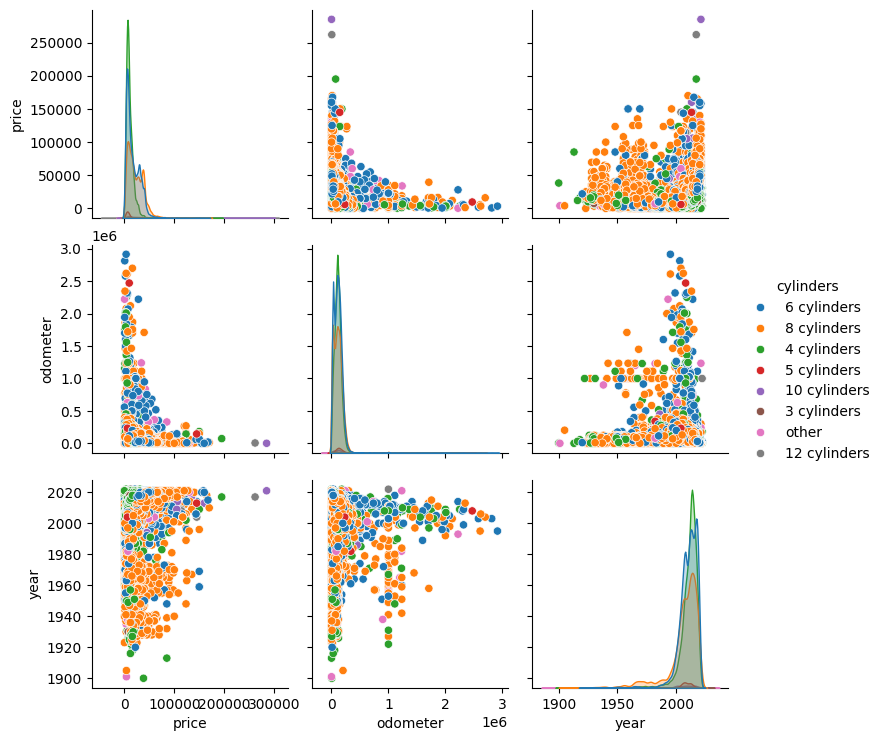

In [16]:
sns.pairplot(cars[['price', 'odometer', 'year', 'cylinders', 'condition']], diag_kind='kde', hue='cylinders')

**Observations**
- Data looks clean and ready
- year to price and odometer correlations are messier
- odometer to price correlation clearly indicates that cars with less miles sell for more
- most cars are 4, 6, and 8 cylinders. Very little of other types.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

**Define several models**

In [17]:
# define the feature data frame, and the target vector
X = cars[cars.columns.drop(['cylinders', 'condition', 'title_status', 'price'])]
y = cars['price']

In [18]:
# create a baseline model
baseline = Pipeline([
  ('imputter', SimpleImputer(strategy='mean')),
  ('scale', StandardScaler()),
  ('linreg', LinearRegression())
])
baseline

Pipeline(steps=[('imputter', SimpleImputer()), ('scale', StandardScaler()),
                ('linreg', LinearRegression())])

In [19]:
# evaluate the baseline model
mse_num_train, mse_num_test, r2_num_train, r2_num_test = \
  train_and_evaluate_model(baseline, 'baseline', X[['year', 'odometer']], y)

MSE on baseline training data set 144090867.654
MSE on baseline test data set 146153834.44160548
R2 on baseline training data set 0.22334245950456522
R2 on baseline test data set 0.2200419085860471


**Observations**
- Weak correlation coefficient.

In [20]:
# generate polynomial features
quad = Pipeline([
  ('imputter', SimpleImputer(strategy='mean')),
  ('quad', PolynomialFeatures(degree=2)),
  ('scale', StandardScaler()),
  ('linreg', LinearRegression())
])
quad

Pipeline(steps=[('imputter', SimpleImputer()), ('quad', PolynomialFeatures()),
                ('scale', StandardScaler()), ('linreg', LinearRegression())])

In [21]:
mse_quad_train, mse_quad_test, r2_quad_train, r2_quad_test = \
  train_and_evaluate_model(quad, 'quad', X[['year', 'odometer']], y)

MSE on quad training data set 114140797.376
MSE on quad test data set 116701052.655745
R2 on quad training data set 0.3838124181249988
R2 on quad test data set 0.3800841423855268


**Observations**
- Polynomial features resulted in better correlation scores.

**Full model leveraging all the features available**

In [22]:
preprocessor = ColumnTransformer(
  [
    (
      'categorical_features',
      make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore')
      ),
      X.select_dtypes(include='object').columns.to_list()
    ),
    (
      'numerical_features',
      make_pipeline(
        SimpleImputer(strategy='mean'),
        PolynomialFeatures(degree=2),
        StandardScaler()
      ),
      ['year', 'odometer']
    )
  ],
  # ordinal features
  remainder=SimpleImputer(strategy='most_frequent'),
)

In [23]:
# Linear regression model using all features
linear = Pipeline([
  ('preprocessor', preprocessor),
  ('regression', LinearRegression()),
])
linear

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=SimpleImputer(strategy='most_frequent'),
                                   transformers=[('categorical_features',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['manufacturer', 'fuel',
                                                   'transmission', 'drive',
                                                   'type', 'paint_color',
                                                   'state']),
                                                 ('numerical_features',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer'])])),
                ('regression', LinearRegression())])

In [24]:
mse_linear_train, mse_linear_test, r2_linear_train, r2_linear_test = \
  train_and_evaluate_model(linear, 'linear', X, y)

MSE on linear training data set 61785497.728
MSE on linear test data set 61720390.53160238
R2 on linear training data set 0.6682926223477574
R2 on linear test data set 0.666688206993918


In [25]:
# Ridge regression model using all features
ridge = Pipeline([
  ('preprocessor', preprocessor),
  ('regression', Ridge()),
])
ridge

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=SimpleImputer(strategy='most_frequent'),
                                   transformers=[('categorical_features',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['manufacturer', 'fuel',
                                                   'transmission', 'drive',
                                                   'type', 'paint_color',
                                                   'state']),
                                                 ('numerical_features',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer'])])),
                ('regression', Ridge())])

In [26]:
mse_ridge_train, mse_ridge_test, r2_ridge_train, r2_ridge_test = \
  train_and_evaluate_model(ridge, 'ridge', X, y)

MSE on ridge training data set 63040660.007
MSE on ridge test data set 66809913.554824606
R2 on ridge training data set 0.6578920733245519
R2 on ridge test data set 0.6504915434206486


In [27]:
# Lasso regression model with all features
lasso = Pipeline([
  ('preprocessor', preprocessor),
  ('regression', Lasso()),
])
lasso

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=SimpleImputer(strategy='most_frequent'),
                                   transformers=[('categorical_features',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['manufacturer', 'fuel',
                                                   'transmission', 'drive',
                                                   'type', 'paint_color',
                                                   'state']),
                                                 ('numerical_features',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer'])])),
                ('regression', Lasso())])

In [28]:
mse_lasso_train, mse_lasso_test, r2_lasso_train, r2_lasso_test = \
  train_and_evaluate_model(lasso, 'lasso', X, y)

MSE on lasso training data set 75143740.721
MSE on lasso test data set 70858709.65961573
R2 on lasso training data set 0.5976638067070761
R2 on lasso test data set 0.6141888426964475


**Observations**
- Linear and Ridge appear to be similar. Some indication of slight overfitting. Will use Ridge regression with cross validation to avoid overfitting.
- Lasso very slow to evaluate.

In [29]:
# Ridge regression with feature selection
selected = Pipeline([
  ('preprocessor', preprocessor),
  ('selector', SelectFromModel(Lasso())),
  ('regression', Ridge()),
])
selected

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=SimpleImputer(strategy='most_frequent'),
                                   transformers=[('categorical_features',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['manufacturer', 'fuel',
                                                   'transmission', 'drive',
                                                   'type', 'paint_color',
                                                   'state']),
                                                 ('numerical_features',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer'])])),
                ('selector', SelectFromModel(estimator=Lasso())),
                ('regression', Ridge())])

In [30]:
mse_selected_train, mse_selected_test, r2_selected_train, r2_selected_test = \
  train_and_evaluate_model(selected, 'selected', X, y)

MSE on selected training data set 62778719.091
MSE on selected test data set 67511788.8005959
R2 on selected training data set 0.6610152900215551
R2 on selected test data set 0.6416162453869296


**Comparison of the models**

In [31]:
pd.DataFrame(
  {
    'MSE train': np.array([mse_num_train, mse_quad_train, mse_linear_train, mse_ridge_train, mse_lasso_train, mse_selected_train]),
    'MSE test': np.array([mse_num_test, mse_quad_test, mse_linear_test, mse_ridge_test, mse_lasso_test, mse_selected_test]),
    'R2 train': np.array([r2_num_train, r2_quad_train, r2_linear_train, r2_ridge_train, r2_lasso_train, r2_selected_train]),
    'R2 test': np.array([r2_num_test, r2_quad_test, r2_linear_test, r2_ridge_test, r2_lasso_test, r2_selected_test]),
  },
  index=['baseline', 'quad', 'linear', 'ridge', 'lasso', 'selected']
).sort_values('R2 test', ascending=False).style.format(precision=3)

,MSE train,MSE test,R2 train,R2 test
linear,61785497.728,61720390.532,0.668,0.667
ridge,63040660.007,66809913.555,0.658,0.650
selected,62778719.091,67511788.801,0.661,0.642
lasso,75143740.721,70858709.660,0.598,0.614
quad,114140797.376,116701052.656,0.384,0.380
baseline,144090867.654,146153834.442,0.223,0.220


**Cross Validation**

In [32]:
# hyper parameter
params_dict = {
  'selector__estimator__alpha': [.0001, .001, .01, .1, 1, 10, 100],
  'regression__alpha': [.0001, .001, .01, .1, 1, 10, 100],
}

# k-fold validation
k = 3 # reasonable value, large data set, just want to train on all data

# perform k-fold cross-validation
finder = GridSearchCV(
  estimator=selected,
  param_grid=params_dict,
  scoring='neg_mean_squared_error',
  cv=k,
)
finder.fit(X, y)  # use the entire set
best_model = finder.best_estimator_

print('Best selector alpha:', best_model.get_params()['selector__estimator__alpha'])
print('Best ridge alpha:', best_model.get_params()['regression__alpha'])

mse_best_train, mse_best_test, r2_best_train, r2_best_test = \
  train_and_evaluate_model(best_model, 'best', X, y)

Best selector alpha: 0.01
Best ridge alpha: 0.0001
MSE on best training data set 61786128.334
MSE on best test data set 61716076.07905477
R2 on best training data set 0.6678576223700802
R2 on best test data set 0.6680084728998771


In [33]:
pd.DataFrame(
  {
    'MSE train': np.array([mse_num_train, mse_quad_train, mse_linear_train, mse_ridge_train, mse_lasso_train, mse_selected_train, mse_best_train]),
    'MSE test': np.array([mse_num_test, mse_quad_test, mse_linear_test, mse_ridge_test, mse_lasso_test, mse_selected_test, mse_best_test]),
    'R2 train': np.array([r2_num_train, r2_quad_train, r2_linear_train, r2_ridge_train, r2_lasso_train, r2_selected_train, r2_best_train]),
    'R2 test': np.array([r2_num_test, r2_quad_test, r2_linear_test, r2_ridge_test, r2_lasso_test, r2_selected_test, r2_best_test]),
  },
  index=['baseline', 'quad', 'linear', 'ridge', 'lasso', 'selected', 'best']
).sort_values('R2 test', ascending=False).style.format(precision=4)

,MSE train,MSE test,R2 train,R2 test
best,61786128.3339,61716076.0791,0.6679,0.6680
linear,61785497.7277,61720390.5316,0.6683,0.6667
ridge,63040660.0073,66809913.5548,0.6579,0.6505
selected,62778719.0906,67511788.8006,0.6610,0.6416
lasso,75143740.7210,70858709.6596,0.5977,0.6142
quad,114140797.3760,116701052.6557,0.3838,0.3801
baseline,144090867.6535,146153834.4416,0.2233,0.2200


**Observations**

Linear model performs close, if not better, than the best model from the cross validation process, and runs much faster.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

**Observations**
- linear model is nearly as good as cross validated model, but much faster
- demonstrates significant accuracy in predicting price: R2 score on test data of 0.67
  - suggests the model has learned what factors influence price of cars, but may not be able to predict the price exactly.

**Permutation Sensitivity Analysis**

In [ ]:
# permutation sensitivity
perm_importance = permutation_importance(
  best_model, 
  X, y, 
  n_repeats = 10,
  scoring='neg_mean_squared_error',
  max_samples=.05
)

df = pd.DataFrame(perm_importance['importances'])
df = df.T
df.columns = X.columns
df.rename(columns={'cylinders_ordered': 'cylinders', 'condition_ordered': 'condition', 'title_status_ordered':'title_status'}, inplace=True)
fig = px.box(data_frame=df, orientation='h', title = 'Feature importance for price prediction')
fig.write_image('images/feature_importance.png')
fig.show()

### Visualizing the Results

**Cluster Analysis**

In [35]:
cluster = Pipeline([
  ('preprocessor', preprocessor),
  ('pca', PCA()),
])
cluster

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=SimpleImputer(strategy='most_frequent'),
                                   transformers=[('categorical_features',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['manufacturer', 'fuel',
                                                   'transmission', 'drive',
                                                   'type', 'paint_color',
                                                   'state']),
                                                 ('numerical_features',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer'])])),
                ('pca', PCA())])

In [36]:
components = cluster.fit_transform(cars.drop(columns=['condition', 'cylinders', 'title_status', 'price']))
kmeans = KMeans().fit(components)
cars['cluster'] = kmeans.labels_
cars.sample(5)

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,cylinders_ordered,condition_ordered,title_status_ordered,cluster
223686,26895,2016.0,gmc,excellent,6 cylinders,gas,44650.0,clean,automatic,4wd,SUV,white,mt,5.0,0.0,0.0,1
154987,32999,2008.0,gmc,like new,8 cylinders,diesel,64000.0,clean,automatic,4wd,truck,black,in,6.0,3.0,0.0,2
243072,22500,1976.0,rover,excellent,4 cylinders,gas,59096.0,clean,manual,4wd,SUV,white,nc,3.0,0.0,0.0,3
400711,2000,1993.0,toyota,fair,4 cylinders,gas,238034.0,clean,automatic,fwd,sedan,yellow,wa,3.0,1.0,0.0,5
316063,2000,2006.0,chevrolet,fair,6 cylinders,gas,160000.0,clean,automatic,fwd,sedan,silver,or,5.0,1.0,0.0,0


In [ ]:
fig = px.scatter(cars, x='odometer', y='price', color='cluster')
fig.update_traces(marker=dict(size=3))
fig.update_layout(title_text=f'Odometer vs Price')
fig.write_image('images/odometer_price.png')
fig.show()

In [ ]:
fig = px.scatter_3d(cars, x='odometer', y='year', z='price', color='cluster')
fig.update_traces(marker=dict(size=3))
fig.update_layout(title_text=f'Odometer & Year vs Price')
fig.show()

In [ ]:
plot_features(cars, ['odometer', 'condition', 'cylinders'])

In [ ]:
plot_features(cars, ['year', 'type', 'fuel'])

In [ ]:
plot_features(cars, ['type', 'drive'])

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

- Methodology
  - data cleaning and prep resulting in data set of > 120k samples
  - exploring several models and concluding that linear regression model with polynomial feature generation of year and odometer resulted in reasonable predictions with R2 of roughly 0.67
- After confirming that model can make decent predictions
  - perform sensitivity analysis to determine which features are important to price
  - run a cluster analysis of the features and plot against price with cluster as a color to visualize groupings
- Provide recommendations to fine tune inventory

In [42]:
n = 1
pd.concat([
  cars.groupby('year').describe()[['price']].droplevel(0, axis=1).sort_values('75%', ascending=False).query('count > 100').head(n),
  cars.groupby('fuel').describe()[['price']].droplevel(0, axis=1).sort_values('75%', ascending=False).query('count > 100').head(n),
  cars.groupby('type').describe()[['price']].droplevel(0, axis=1).sort_values('75%', ascending=False).query('count > 100').head(n),
  cars.groupby('manufacturer').describe()[['price']].droplevel(0, axis=1).sort_values('75%', ascending=False).query('count > 100').head(n),
  cars.groupby('cylinders').describe()[['price']].droplevel(0, axis=1).sort_values('75%', ascending=False).query('count > 100').head(n),
  cars.groupby('drive').describe()[['price']].droplevel(0, axis=1).sort_values('75%', ascending=False).query('count > 100').head(n),
])

,count,mean,std,min,25%,50%,75%,max
2021.0,240.0,47844.150000,31984.565482,25.0,27975.00,41000.0,59996.25,285000.0
diesel,7302.0,29528.852095,18651.501129,3.0,14975.50,27490.0,39990.00,167500.0
other,3452.0,27213.036501,13198.753430,5.0,16872.00,29990.0,36990.00,158000.0
porsche,352.0,30119.252841,24627.691986,995.0,13000.00,21500.0,38900.00,150000.0
8 cylinders,34963.0,21938.660355,15786.989638,4.0,9000.00,18500.0,32995.00,169999.0
4wd,47868.0,19896.888339,14517.841113,3.0,8368.75,15999.0,29900.00,195000.0


In [43]:
cars.groupby('type').describe()[['price']].droplevel(0, axis=1).sort_values('75%', ascending=False).query('count > 100').head(3)


,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
other,3452.0,27213.036501,13198.753430,5.0,16872.0,29990.0,36990.0,158000.0
coupe,8608.0,21285.786013,17133.568130,8.0,6999.0,17000.0,34990.0,285000.0
pickup,12764.0,23772.299906,14172.853639,6.0,11000.0,24995.0,34590.0,114999.0


**Conclusions**
- Dealers looking to maximize the price of the cars they sell should consider
  - newer, low mileage cars
  - diesel
  - coupes or pickups
  - porshce
  - 8 cylinders
  - 4wd